# Evrard Collapse
The Evrard collapse problem tests the ability of the code to couple hydrodynamics and self-gravity. In this problem, we have a non-rotating isothermal gas sphere of mass and radius 1. Initially, the mass will fall towards the center because of the self gravity of the system, causing the pressure to rise. This produces a shock that travels outwards through the infalling gas, resulting in a spherical distribution of gas in hydrostatic virial equilibrium. 

For this problem, we initialize a density profile of 
$$ \rho(r)=   \left\{
\begin{array}{ll}
      1/(2\pi r) & r\leq 1 \\
      0 & r> 1 \\
\end{array} 
\right.  
$$
and pressure of
$$ P(r)=   \left\{
\begin{array}{ll}
      0.05/(3\pi r) & r\leq 1 \\
      0 & r> 1 \\
\end{array} 
\right.  
$$

In initializing the domain, we center the sphere at (1.25, 1.25, 1.25), but because the density profile goes as $1/r$, the Cartesian mesh will not be able to resolve the high density values. To work around this, we transform the radial positions of particles such that $r_\mathrm{new} = r_\mathrm{old}^{3/2}$, which maps a grid of equally spaced particles of uniform density to one wherein the density follows a $1/r$ profile.

In [1]:
import phd
import numpy as np

In [2]:
def create_particles(dim=3, gamma=1.4):

    L = 2.5     # domain size in x
    n = 33      # particles per dim
    dx = L/n
    num = n**3  # number of points

    M = 1.0
    R = 1.0
    G = 1.0
    u = 0.05*G*M/R
    c = 1.25

    rho_fac = M/(2.*np.pi*R**2)
    pre_fac = 2.*rho_fac*u/3.

    # create particle container
    particles = phd.HydroParticleCreator(num, dim=3)
    part = 0
    for i in range(n):
        for j in range(n):
            for k in range(n):

                x = (i+0.5)*dx
                y = (j+0.5)*dx
                z = (k+0.5)*dx

                r = np.sqrt((x-c)**2 + (y-c)**2 + (z-c)**2)

                if r <= R:

                    # stretch
                    rn = r**1.5 + 0.001
                    xn = x-c; yn = y-c; zn = z - c

                    theta = np.arctan2(np.sqrt(xn**2 + yn**2),zn)
                    phi = np.arctan2(yn,xn)

                    particles["position-x"][part] = rn*np.sin(theta)*np.cos(phi) + c
                    particles["position-y"][part] = rn*np.sin(theta)*np.sin(phi) + c
                    particles["position-z"][part] = rn*np.cos(theta) + c

                    particles["density"][part] = rho_fac/rn
                    particles["pressure"][part] = pre_fac/rn

                else:
                    particles["density"][part] = 1.e-5*rho_fac/R
                    particles["pressure"][part] = 1.e-5*pre_fac/R

                    particles["position-x"][part] = x
                    particles["position-y"][part] = y 
                    particles["position-z"][part] = z

                particles["ids"][part] = part
                part += 1

    # zero out velocities and set particle type
    particles["velocity-x"][:] = 0.0
    particles["velocity-y"][:] = 0.0
    particles["velocity-z"][:] = 0.0

    return particles

In [3]:
dim = 3; gamma = 5./3.
particles = phd.distribute_initial_particles(
        create_particles, dim=dim, gamma=gamma)

# computation related to boundaries
domain_manager = phd.DomainManager(
        xmin=[0., 0., 0.], xmax=[2.5, 2.5, 2.5],
        initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh()

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Reflective())
integrator.set_reconstruction(phd.PieceWiseLinear())
integrator.set_equation_state(phd.IdealGas(gamma=gamma))

sim_name = "evrard"
if phd._in_parallel:
    integrator.set_load_balance(phd.LoadBalance())
    sim_name = "mpi_evrard"

gravity = phd.SelfGravity()
gravity_tree = phd.GravityTree(barnes_angle=0.5, smoothing_length=0.003, calculate_potential=1)
gravity_tree.register_fields(integrator.particles)
gravity_tree.add_fields(integrator.particles)
gravity_tree.set_domain_manager(domain_manager)
gravity_tree.initialize()
gravity.set_gravity(gravity_tree)
integrator.add_source_term(gravity)

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=0.81))

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

output = phd.TimeInterval(time_interval=0.01)
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# Create simulator
simulation = phd.Simulation(simulation_name=sim_name)
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [INFO     ] 2021-06-04 11:49:32,559: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: evrard.log
Problem solving: evrard
Output data will be saved at: evrard_output

Classes used in the simulation
------------------------------
boundary_condition: Reflective
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh
particles: CarrayContainer
reconstruction: PieceWiseLinear
riemann: HLLC

phd: [INFO     ] 2021-06-04 11:49:32,561: IntegrateBase: Building initial mesh
phd: [INFO     ] 2021-06-04 11:49:32,561: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:49:35,490: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:49:36,022: Beginning integration loop
phd: [INFO     ] 2021-0

phd: [INFO     ] 2021-06-04 11:49:49,861: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:49:50,204: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:49:50,298: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:49:50,355: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:49:50,357: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:49:50,407: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:49:51,613: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:49:52,138: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:49:52,156: hdf5 format: Writting time_interval0005.hdf5
phd: [INFO     ] 2021-06-04 11:49:52,179: Hydro dt: 0.034920
phd: [INFO     ] 2021-06-04 11:49:52,180: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:49:52,185: SelfGravity: Gravity dt: 0.044970
phd: [INFO     ] 2021-06-04 

phd: [INFO     ] 2021-06-04 11:50:05,023: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:50:05,080: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:50:05,082: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:50:05,132: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:50:06,357: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:50:06,887: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:50:06,905: hdf5 format: Writting time_interval0011.hdf5
phd: [INFO     ] 2021-06-04 11:50:06,933: Hydro dt: 0.031345
phd: [INFO     ] 2021-06-04 11:50:06,934: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:50:06,939: SelfGravity: Gravity dt: 0.045896
phd: [INFO     ] 2021-06-04 11:50:06,939: Source dt: 0.045896
phd: [INFO     ] 2021-06-04 11:50:06,939: Starting iteration: 12 time: 0.120000 dt: 0.010000
phd: [INFO     ] 2021-06-04 11:50:06,940: MovingMesh

phd: [INFO     ] 2021-06-04 11:50:19,808: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:50:19,810: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:50:19,860: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:50:21,074: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:50:21,610: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:50:21,629: hdf5 format: Writting time_interval0017.hdf5
phd: [INFO     ] 2021-06-04 11:50:21,653: Hydro dt: 0.025779
phd: [INFO     ] 2021-06-04 11:50:21,653: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:50:21,659: SelfGravity: Gravity dt: 0.039407
phd: [INFO     ] 2021-06-04 11:50:21,660: Source dt: 0.039407
phd: [INFO     ] 2021-06-04 11:50:21,660: Starting iteration: 18 time: 0.180000 dt: 0.010000
phd: [INFO     ] 2021-06-04 11:50:21,660: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:50:21,755: PieceWiseLinear

phd: [INFO     ] 2021-06-04 11:50:34,489: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:50:35,693: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:50:36,239: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:50:36,258: hdf5 format: Writting time_interval0023.hdf5
phd: [INFO     ] 2021-06-04 11:50:36,282: Hydro dt: 0.018463
phd: [INFO     ] 2021-06-04 11:50:36,282: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:50:36,288: SelfGravity: Gravity dt: 0.030077
phd: [INFO     ] 2021-06-04 11:50:36,288: Source dt: 0.030077
phd: [INFO     ] 2021-06-04 11:50:36,289: Starting iteration: 24 time: 0.240000 dt: 0.010000
phd: [INFO     ] 2021-06-04 11:50:36,289: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:50:36,385: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:50:36,732: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 

phd: [INFO     ] 2021-06-04 11:50:50,962: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:50:50,984: hdf5 format: Writting time_interval0029.hdf5
phd: [INFO     ] 2021-06-04 11:50:51,017: Hydro dt: 0.012750
phd: [INFO     ] 2021-06-04 11:50:51,017: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:50:51,023: SelfGravity: Gravity dt: 0.022486
phd: [INFO     ] 2021-06-04 11:50:51,024: Source dt: 0.022486
phd: [INFO     ] 2021-06-04 11:50:51,025: Starting iteration: 30 time: 0.300000 dt: 0.010000
phd: [INFO     ] 2021-06-04 11:50:51,025: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:50:51,123: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:50:51,500: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:50:51,601: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:50:51,664: SelfGravity: Applying gravity to primitive
phd

phd: [INFO     ] 2021-06-04 11:51:06,162: Hydro dt: 0.009947
phd: [INFO     ] 2021-06-04 11:51:06,163: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:51:06,168: SelfGravity: Gravity dt: 0.024416
phd: [INFO     ] 2021-06-04 11:51:06,168: Source dt: 0.024416
phd: [INFO     ] 2021-06-04 11:51:06,168: Starting iteration: 36 time: 0.360000 dt: 0.009947
phd: [INFO     ] 2021-06-04 11:51:06,169: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:51:06,268: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:51:06,625: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:51:06,722: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:51:06,781: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:51:06,783: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:51:06,844: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:51:08,050: 

phd: [INFO     ] 2021-06-04 11:51:20,900: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:51:20,994: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:51:21,345: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:51:21,442: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:51:21,501: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:51:21,503: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:51:21,553: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:51:22,747: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:51:23,294: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:51:23,315: Hydro dt: 0.008618
phd: [INFO     ] 2021-06-04 11:51:23,315: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:51:23,320: SelfGravity: Gravity dt: 0.021891
phd: [INFO     ] 2021-06-04 

phd: [INFO     ] 2021-06-04 11:51:36,260: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:51:36,262: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:51:36,314: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:51:37,554: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:51:38,113: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:51:38,135: Hydro dt: 0.007769
phd: [INFO     ] 2021-06-04 11:51:38,135: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:51:38,140: SelfGravity: Gravity dt: 0.020279
phd: [INFO     ] 2021-06-04 11:51:38,141: Source dt: 0.020279
phd: [INFO     ] 2021-06-04 11:51:38,141: Starting iteration: 49 time: 0.427999 dt: 0.002001
phd: [INFO     ] 2021-06-04 11:51:38,142: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:51:38,239: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:51:38,588: PieceWiseLinea

phd: [INFO     ] 2021-06-04 11:51:52,981: Hydro dt: 0.006779
phd: [INFO     ] 2021-06-04 11:51:52,981: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:51:52,987: SelfGravity: Gravity dt: 0.018284
phd: [INFO     ] 2021-06-04 11:51:52,987: Source dt: 0.018284
phd: [INFO     ] 2021-06-04 11:51:52,988: Starting iteration: 55 time: 0.457040 dt: 0.002960
phd: [INFO     ] 2021-06-04 11:51:52,988: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:51:53,084: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:51:53,436: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:51:53,533: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:51:53,592: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:51:53,594: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:51:53,645: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:51:54,851: 

phd: [INFO     ] 2021-06-04 11:52:07,865: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:52:07,963: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:52:08,314: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:52:08,411: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:52:08,470: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:52:08,472: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:52:08,523: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:52:09,738: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:52:10,302: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:52:10,322: hdf5 format: Writting time_interval0048.hdf5
phd: [INFO     ] 2021-06-04 11:52:10,354: Hydro dt: 0.005760
phd: [INFO     ] 2021-06-04 11:52:10,355: SelfGravity: Compute gravitational time step
phd: [INFO     ] 

phd: [INFO     ] 2021-06-04 11:52:23,322: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:52:23,324: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:52:23,375: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:52:24,579: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:52:25,137: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:52:25,155: hdf5 format: Writting time_interval0051.hdf5
phd: [INFO     ] 2021-06-04 11:52:25,179: Hydro dt: 0.005137
phd: [INFO     ] 2021-06-04 11:52:25,180: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:52:25,185: SelfGravity: Gravity dt: 0.015344
phd: [INFO     ] 2021-06-04 11:52:25,185: Source dt: 0.015344
phd: [INFO     ] 2021-06-04 11:52:25,186: Starting iteration: 68 time: 0.520000 dt: 0.005137
phd: [INFO     ] 2021-06-04 11:52:25,186: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:52:25,283: PieceWiseLinear

phd: [INFO     ] 2021-06-04 11:52:42,701: Hydro dt: 0.004681
phd: [INFO     ] 2021-06-04 11:52:42,702: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:52:42,707: SelfGravity: Gravity dt: 0.014400
phd: [INFO     ] 2021-06-04 11:52:42,708: Source dt: 0.014400
phd: [INFO     ] 2021-06-04 11:52:42,708: Starting iteration: 74 time: 0.544752 dt: 0.004681
phd: [INFO     ] 2021-06-04 11:52:42,708: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:52:42,806: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:52:43,159: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:52:43,254: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:52:43,314: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:52:43,316: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:52:43,368: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:52:44,576: 

phd: [INFO     ] 2021-06-04 11:52:57,619: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:52:57,972: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:52:58,067: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:52:58,126: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:52:58,128: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:52:58,180: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:52:59,423: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:52:59,982: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:53:00,003: Hydro dt: 0.004221
phd: [INFO     ] 2021-06-04 11:53:00,003: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:53:00,008: SelfGravity: Gravity dt: 0.013565
phd: [INFO     ] 2021-06-04 11:53:00,009: Source dt: 0.013565
phd: [INFO     ] 2021-06-04 11:53:00,009: Starting it

phd: [INFO     ] 2021-06-04 11:53:14,386: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:53:14,946: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:53:14,967: Hydro dt: 0.003966
phd: [INFO     ] 2021-06-04 11:53:14,968: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:53:14,973: SelfGravity: Gravity dt: 0.013099
phd: [INFO     ] 2021-06-04 11:53:14,973: Source dt: 0.013099
phd: [INFO     ] 2021-06-04 11:53:14,973: Starting iteration: 87 time: 0.588068 dt: 0.001932
phd: [INFO     ] 2021-06-04 11:53:14,974: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:53:15,071: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:53:15,425: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:53:15,520: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:53:15,580: SelfGravity: Applying gravity to primitive
phd: [INF

phd: [INFO     ] 2021-06-04 11:53:29,978: Starting iteration: 93 time: 0.607648 dt: 0.002352
phd: [INFO     ] 2021-06-04 11:53:29,978: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:53:30,077: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:53:30,430: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:53:30,533: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:53:30,595: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:53:30,597: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:53:30,651: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:53:31,867: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:53:32,427: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:53:32,445: hdf5 format: Writting time_interval0060.hdf5
phd: [INFO     ] 2021-06-04 11:53:32,469: Hydro dt: 0.003716
phd: [INFO 

phd: [INFO     ] 2021-06-04 11:53:45,653: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:53:45,655: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:53:45,708: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:53:46,923: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:53:47,490: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:53:47,508: hdf5 format: Writting time_interval0062.hdf5
phd: [INFO     ] 2021-06-04 11:53:47,536: Hydro dt: 0.003401
phd: [INFO     ] 2021-06-04 11:53:47,536: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:53:47,541: SelfGravity: Gravity dt: 0.011587
phd: [INFO     ] 2021-06-04 11:53:47,541: Source dt: 0.011587
phd: [INFO     ] 2021-06-04 11:53:47,542: Starting iteration: 100 time: 0.630000 dt: 0.003401
phd: [INFO     ] 2021-06-04 11:53:47,542: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:53:47,641: PieceWiseLinea

phd: [INFO     ] 2021-06-04 11:54:02,557: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:54:02,563: SelfGravity: Gravity dt: 0.011122
phd: [INFO     ] 2021-06-04 11:54:02,563: Source dt: 0.011122
phd: [INFO     ] 2021-06-04 11:54:02,563: Starting iteration: 106 time: 0.649703 dt: 0.000297
phd: [INFO     ] 2021-06-04 11:54:02,564: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:54:02,663: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:54:03,021: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:54:03,126: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:54:03,190: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:54:03,192: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:54:03,246: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:54:04,481: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021

phd: [INFO     ] 2021-06-04 11:54:18,276: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:54:18,381: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:54:18,444: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:54:18,446: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:54:18,500: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:54:19,719: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:54:20,288: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:54:20,309: Hydro dt: 0.003016
phd: [INFO     ] 2021-06-04 11:54:20,310: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:54:20,315: SelfGravity: Gravity dt: 0.010830
phd: [INFO     ] 2021-06-04 11:54:20,315: Source dt: 0.010830
phd: [INFO     ] 2021-06-04 11:54:20,315: Starting iteration: 113 time: 0.666122 dt: 0.003016
phd: [INFO     ] 2021-06-04 11:54:20,316: Movin

phd: [INFO     ] 2021-06-04 11:54:35,442: hdf5 format: Writting time_interval0067.hdf5
phd: [INFO     ] 2021-06-04 11:54:35,470: Hydro dt: 0.002915
phd: [INFO     ] 2021-06-04 11:54:35,470: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:54:35,476: SelfGravity: Gravity dt: 0.010610
phd: [INFO     ] 2021-06-04 11:54:35,476: Source dt: 0.010610
phd: [INFO     ] 2021-06-04 11:54:35,476: Starting iteration: 119 time: 0.680000 dt: 0.002915
phd: [INFO     ] 2021-06-04 11:54:35,477: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:54:35,577: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:54:35,932: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:54:36,035: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:54:36,099: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:54:36,101: HLLC: Starting riemann
phd: [INFO     ] 2021-06-

phd: [INFO     ] 2021-06-04 11:54:50,721: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:54:51,076: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:54:51,179: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:54:51,241: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:54:51,243: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:54:51,298: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:54:52,521: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:54:53,095: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:54:53,117: Hydro dt: 0.002778
phd: [INFO     ] 2021-06-04 11:54:53,117: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:54:53,122: SelfGravity: Gravity dt: 0.010298
phd: [INFO     ] 2021-06-04 11:54:53,123: Source dt: 0.010298
phd: [INFO     ] 2021-06-04 11:54:53,123: Starting it

phd: [INFO     ] 2021-06-04 11:55:07,629: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:55:08,207: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:55:08,228: Hydro dt: 0.002666
phd: [INFO     ] 2021-06-04 11:55:08,228: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:55:08,233: SelfGravity: Gravity dt: 0.010044
phd: [INFO     ] 2021-06-04 11:55:08,234: Source dt: 0.010044
phd: [INFO     ] 2021-06-04 11:55:08,234: Starting iteration: 132 time: 0.712689 dt: 0.002666
phd: [INFO     ] 2021-06-04 11:55:08,234: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:55:08,334: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:55:08,702: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:55:08,806: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:55:08,869: SelfGravity: Applying gravity to primitive
phd: [IN

phd: [INFO     ] 2021-06-04 11:55:23,509: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:55:23,609: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:55:23,965: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:55:24,069: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:55:24,132: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:55:24,134: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:55:24,190: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:55:25,417: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:55:25,995: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:55:26,014: hdf5 format: Writting time_interval0072.hdf5
phd: [INFO     ] 2021-06-04 11:55:26,039: Hydro dt: 0.002550
phd: [INFO     ] 2021-06-04 11:55:26,040: SelfGravity: Compute gravitational time step
phd: [INFO     ] 

phd: [INFO     ] 2021-06-04 11:55:39,337: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:55:39,392: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:55:40,680: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:55:41,267: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:55:41,288: Hydro dt: 0.002453
phd: [INFO     ] 2021-06-04 11:55:41,289: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:55:41,294: SelfGravity: Gravity dt: 0.009532
phd: [INFO     ] 2021-06-04 11:55:41,294: Source dt: 0.009532
phd: [INFO     ] 2021-06-04 11:55:41,294: Starting iteration: 145 time: 0.744960 dt: 0.002453
phd: [INFO     ] 2021-06-04 11:55:41,295: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:55:41,394: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:55:41,749: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:55:41,853: PieceWi

phd: [INFO     ] 2021-06-04 11:55:56,588: Source dt: 0.009367
phd: [INFO     ] 2021-06-04 11:55:56,588: Starting iteration: 151 time: 0.757235 dt: 0.002383
phd: [INFO     ] 2021-06-04 11:55:56,588: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:55:56,688: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:55:57,045: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:55:57,149: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:55:57,212: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:55:57,214: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:55:57,269: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:55:58,492: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:55:59,070: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:55:59,091: Hydro dt: 0.002367
phd: [INFO     ] 2021-06-04 11:55:5

phd: [INFO     ] 2021-06-04 11:56:12,612: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:56:12,667: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:56:13,890: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:56:14,471: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:56:14,490: hdf5 format: Writting time_interval0076.hdf5
phd: [INFO     ] 2021-06-04 11:56:14,515: Hydro dt: 0.002315
phd: [INFO     ] 2021-06-04 11:56:14,515: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:56:14,520: SelfGravity: Gravity dt: 0.009209
phd: [INFO     ] 2021-06-04 11:56:14,521: Source dt: 0.009209
phd: [INFO     ] 2021-06-04 11:56:14,521: Starting iteration: 158 time: 0.770000 dt: 0.002315
phd: [INFO     ] 2021-06-04 11:56:14,521: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:56:14,621: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:56:14,980: PieceWiseLi

phd: [INFO     ] 2021-06-04 11:56:29,673: SelfGravity: Gravity dt: 0.009104
phd: [INFO     ] 2021-06-04 11:56:29,673: Source dt: 0.009104
phd: [INFO     ] 2021-06-04 11:56:29,673: Starting iteration: 164 time: 0.782273 dt: 0.002264
phd: [INFO     ] 2021-06-04 11:56:29,674: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:56:29,777: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:56:30,135: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:56:30,241: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:56:30,305: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:56:30,307: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:56:30,362: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:56:31,623: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:56:32,205: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 202

phd: [INFO     ] 2021-06-04 11:56:45,604: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:56:45,606: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:56:45,662: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:56:46,888: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:56:47,480: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 2021-06-04 11:56:47,502: Hydro dt: 0.002231
phd: [INFO     ] 2021-06-04 11:56:47,503: SelfGravity: Compute gravitational time step
phd: [INFO     ] 2021-06-04 11:56:47,508: SelfGravity: Gravity dt: 0.008987
phd: [INFO     ] 2021-06-04 11:56:47,508: Source dt: 0.008987
phd: [INFO     ] 2021-06-04 11:56:47,509: Starting iteration: 171 time: 0.796722 dt: 0.002231
phd: [INFO     ] 2021-06-04 11:56:47,509: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:56:47,610: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:56:47,966: PieceWiseLine

phd: [INFO     ] 2021-06-04 11:57:02,809: SelfGravity: Gravity dt: 0.008897
phd: [INFO     ] 2021-06-04 11:57:02,810: Source dt: 0.008897
phd: [INFO     ] 2021-06-04 11:57:02,810: Starting iteration: 177 time: 0.808827 dt: 0.001173
phd: [INFO     ] 2021-06-04 11:57:02,810: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-04 11:57:02,912: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-04 11:57:03,281: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-04 11:57:03,387: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-04 11:57:03,451: SelfGravity: Applying gravity to primitive
phd: [INFO     ] 2021-06-04 11:57:03,454: HLLC: Starting riemann
phd: [INFO     ] 2021-06-04 11:57:03,510: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-04 11:57:04,764: SelfGravity: Calculating accelerations
phd: [INFO     ] 2021-06-04 11:57:05,362: SelfGravity: Applying gravity to conservative
phd: [INFO     ] 202

phd: [INFO     ] 2021-06-04 11:57:29,568: hdf5 format: Reading filename evrard_output/final_output/final_output0000/final_output0000.hdf5


0.81


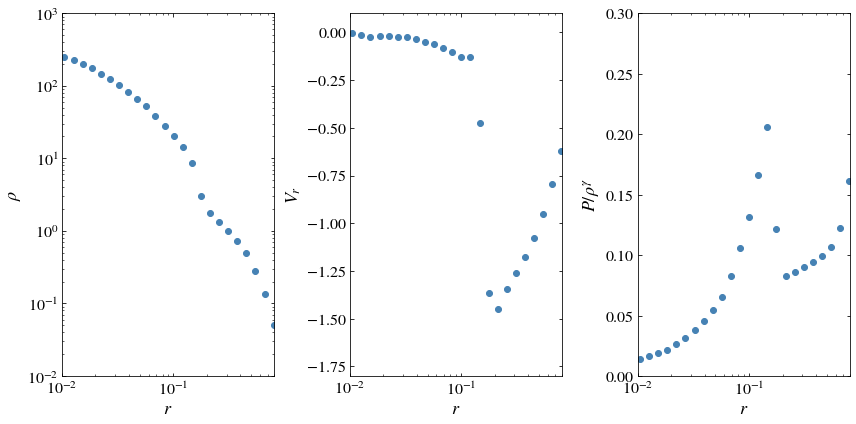

In [4]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16

def radial_profile(particles, field):

    # create radius of particles
    radius = np.sqrt((particles["position-x"]-1.25)**2 +\
            (particles["position-y"]-1.25)**2 +\
            (particles["position-z"]-1.25)**2)

    # create bin radius
    rmin, rmax = min(radius), max(radius)
    radial_bins = np.logspace(-3, 1)

    dr = radial_bins[1:] - radial_bins[0:-1]

    dens = np.zeros(radial_bins.size)
    coun = np.zeros(radial_bins.size)
    for i in range(particles.get_carray_size()):
        index = 0

        if radius[i] < 1.e-3 or radius[i] > 1.:
            continue

        while index+1 < len(radial_bins) and radius[i] > radial_bins[index+1]:
            index += 1
        dens[index] += particles[field][i]
        coun[index] += 1.

    for i in range(len(radial_bins)):
        if coun[i] > 0:
            dens[i] /= coun[i] 

    return radial_bins[0:-1] + 0.5*dr, dens[0:-1] 


#exact = np.loadtxt("exact/profile3d027.txt")

# initial output
io = phd.Hdf5()
#file_name = "evrard2_output/time_interval/time_interval0080/time_interval0080.hdf5"
#file_name = "test_collapse_output/final_output/final_output0000/final_output0000.hdf5"
#file_name = "blnr_output/time_interval/time_interval0080/time_interval0080.hdf5"
file_name = "evrard_output/final_output/final_output0000/final_output0000.hdf5"
particles = io.read(file_name)
particles.remove_tagged_particles(phd.ParticleTAGS.Ghost)

time = h5py.File(file_name, "r").attrs["time"]
print(time)

r = np.sqrt((particles["position-x"]-1.25)**2 + (particles["position-y"]-1.25)**2 + (particles["position-z"]-1.25)**2)
fig, axes = plt.subplots(1,3, figsize=(12,6))
#fig.suptitle("Evrard Collapse Problem: time=%0.2f" % time, fontsize=14)

num_particles = particles.get_carray_size()
particles.register_carray(num_particles, "velocity", "double")
particles.register_carray(num_particles, "entropic", "double")

particles["velocity"][:] = (particles["velocity-x"]*(particles["position-x"]-1.25) +\
        particles["velocity-y"]*(particles["position-y"]-1.25) +\
        particles["velocity-z"]*(particles["position-z"]-1.25))/r
particles["entropic"][:] = particles["pressure"]/particles["density"]**(5/3.)

# create new fields

rad_den, den = radial_profile(particles, "density")
rad_vel, vel = radial_profile(particles, "velocity")
rad_ent, ent = radial_profile(particles, "entropic")

ax = axes[0]
ax.loglog(rad_den, den, 'o', c="steelblue")
#ax.loglog(exact[:,0], exact[:,1], "r-")
ax.set_xlim(1.0E-2, 0.8)
ax.set_ylim(1.0E-2, 1.0E3)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_ylabel(r"$\rho$", fontsize=18)
ax.tick_params(direction="in", right=True, top=True, which="both")

ax = axes[1]
ax.semilogx(rad_vel, vel, 'o', c="steelblue")
#ax.semilogx(exact[:,0], exact[:,2], "r-")
ax.set_xlim(1.0E-2, 0.8)
ax.set_ylim(-1.8, .1)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_ylabel(r"$V_r$", fontsize=18)
ax.tick_params(direction="in", right=True, top=True, which="both")


ax = axes[2]
ax.semilogx(rad_ent, ent, 'o', c="steelblue")
#ax.semilogx(exact[:,0], exact[:,3]/exact[:,1]**(5./3.), "r-")
ax.set_xlim(1.0E-2, 0.8)
ax.set_ylim(0, .3)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_ylabel(r"$P/\rho^\gamma$", fontsize=18)
ax.tick_params(direction="in", right=True, top=True, which="both")
fig.tight_layout()
#fig.subplots_adjust(top=0.9)
#plt.savefig("evrard.eps")
plt.show()